# Experiment Template

**Team Member:** [Your Name]  
**Model:** [e.g., RNN, LSTM, GRU, Logistic Regression]  
**Embedding:** [e.g., TF-IDF, Word2Vec (Skip-gram), GloVe]

---

## 1. Setup & Imports

In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 59.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import os
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

# Download NLTK data
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Set plot style
sns.set(style="whitegrid")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Load Data

In [ ]:
DATA_PATH = '/content/drive/MyDrive/data/IMDB Dataset.csv'
if not os.path.exists(DATA_PATH):
    print(f"Warning: {DATA_PATH} not found. Please ensure the dataset is in the data folder.")
else:
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded successfully: {df.shape}")
    display(df.head())

Dataset loaded successfully: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## 3. Exploratory Data Analysis (EDA)
Understanding the dataset characteristics.

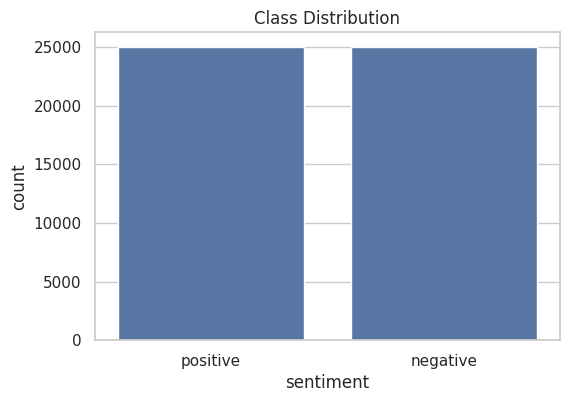

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [ ]:
if 'sentiment' in df.columns:
    # Class Distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x='sentiment', data=df)
    plt.title('Class Distribution')
    plt.show()
    print(df['sentiment'].value_counts())

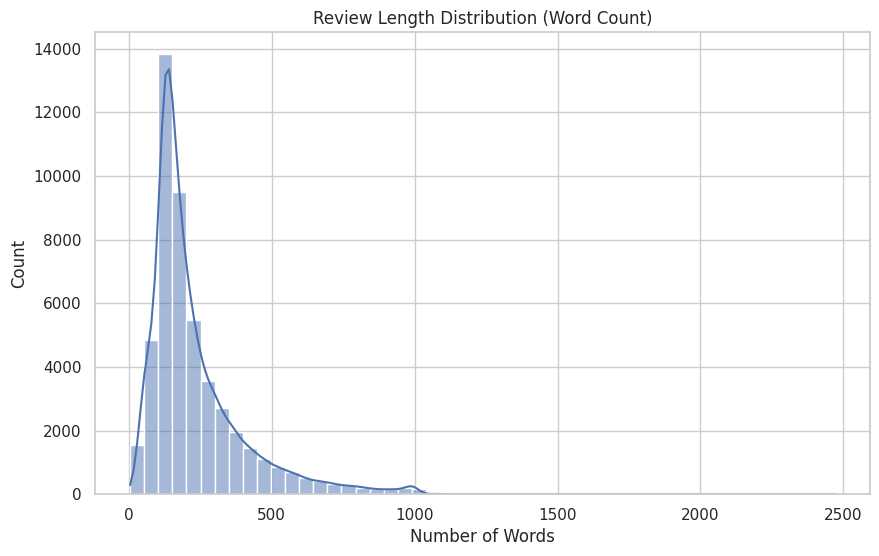

Average word count: 231.16


In [ ]:
# Review Length Analysis
df['word_count'] = df['review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title('Review Length Distribution (Word Count)')
plt.xlabel('Number of Words')
plt.show()

print(f"Average word count: {df['word_count'].mean():.2f}")

## 4. Preprocessing
Applying shared preprocessing strategy:
1. Lowercase
2. Remove HTML tags
3. Remove special characters
4. Tokenize
5. Remove stopwords (Optional based on embedding)

In [ ]:
def clean_text(text, remove_stopwords=True):
    # 1. Lowercase
    text = text.lower()
    # 2. HTML tag removal
    text = re.sub(r'<.*?>', '', text)
    # 3. Remove non-alphanumeric characters (preserving spaces)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # 4. Tokenize
    tokens = word_tokenize(text)

    # 5. Remove stopwords (Optional based on embedding)
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        filtered_tokens = [w for w in tokens if w not in stop_words]
        return " ".join(filtered_tokens)
    else:
        return " ".join(tokens)

# Apply cleaning (Default strategy)
print("Preprocessing data (this may take a moment)...")
df['cleaned_review'] = df['review'].apply(lambda x: clean_text(x, remove_stopwords=True))
display(df[['review', 'cleaned_review']].head())

Preprocessing data (this may take a moment)...


,review,cleaned_review
0,One of the other reviewers has mentioned that ...,one reviewers mentioned watching 1 oz episode ...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stunni...


### Post-Preprocessing Visualization

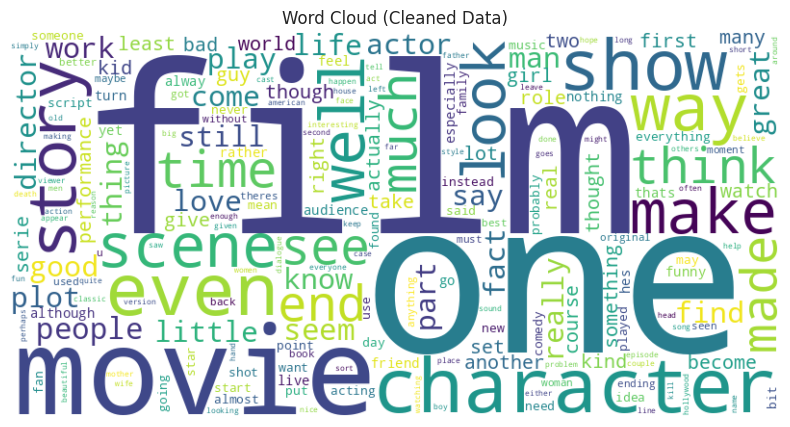

In [ ]:
# Word Cloud for cleaned text
all_text = " ".join(df['cleaned_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Cleaned Data)')
plt.show()

In [ ]:
# Train/Test Split
X = df['cleaned_review'].values
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values # Binary encoding

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 40000
Testing samples: 10000


In [ ]:
# Initialize Vectorizer
tfidf_vec = TfidfVectorizer(max_features=5000, min_df=2, ngram_range=(1,2))

# Transform data
X_train_emb = tfidf_vec.fit_transform(X_train).toarray()
X_test_emb = tfidf_vec.transform(X_test).toarray()

print(f"TF-IDF Shape: {X_train_emb.shape}")

TF-IDF Shape: (40000, 5000)


## 5. Embedding Layer
Implement your specific embedding here (TF-IDF, Skip-gram (Word2Vec) and CBOW (Word2Vec)).

In [ ]:
# Tokenize for Gensim
train_tokens = [s.split() for s in X_train]
test_tokens = [s.split() for s in X_test]

# Train Skip-gram (sg=1)
w2v_sg_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, sg=1, min_count=2)

def get_mean_vector(tokens, model):
    vectors = [model.wv[w] for w in tokens if w in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

X_train_emb = np.array([get_mean_vector(s, w2v_sg_model) for s in train_tokens])
X_test_emb = np.array([get_mean_vector(s, w2v_sg_model) for s in test_tokens])

print(f"Skip-gram Shape: {X_train_emb.shape}")

Skip-gram Shape: (40000, 100)


In [ ]:
# Train CBOW (sg=0)
w2v_cbow_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, sg=0, min_count=2)

X_train_emb = np.array([get_mean_vector(s, w2v_cbow_model) for s in train_tokens])
X_test_emb = np.array([get_mean_vector(s, w2v_cbow_model) for s in test_tokens])

print(f"CBOW Shape: {X_train_emb.shape}")

CBOW Shape: (40000, 100)


## 6. Model Architecture
Define your model (RNN, LSTM, GRU, or Traditional ML).

In [ ]:
# 1. Initialize the Tokenizer
max_words = 10000  # Only keep the top 10k most frequent words
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# 2. Convert text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# 3. Pad sequences so they all have the same length
max_length = 200  # We will look at the first 200 words of each review
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='pre', truncating='pre')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='pre', truncating='pre')

print(f"Shape of padded train data: {X_train_padded.shape}")
print(f"Sample sequence: {X_train_padded[0][:10]}...") # Show first 10 tokens of first review

Shape of padded train data: (40000, 200)
Sample sequence: [   1    1  130 6000   18  753   29 4077   28   40]...


In [ ]:
embedding_dim = 100
word_index = tokenizer.word_index
nb_words = min(max_words, len(word_index) + 1)

# Create an empty matrix
embedding_matrix = np.zeros((nb_words, embedding_dim))

# Fill the matrix with vectors from your Word2Vec model
for word, i in word_index.items():
    if i >= max_words:
        continue
    if word in w2v_cbow_model.wv:
        embedding_matrix[i] = w2v_cbow_model.wv[word]

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (10000, 100)


In [ ]:
# Build the model again with corrections
model = Sequential([
    Embedding(input_dim=nb_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              trainable=False), # Freeze it for now to force the RNN to learn patterns first
    SimpleRNN(32), # Smaller layer to reduce overfitting
    Dense(1, activation='sigmoid')
])

# Use a slower learning rate to prevent the loss from exploding
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# This time, check the summary! Trainable params should be > 0.
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

## 7. Training

In [ ]:
# Train the model
history = model.fit(
    X_train_padded,
    y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 35s 70ms/step - accuracy: 0.5172 - loss: 0.7331 - val_accuracy: 0.5819 - val_loss: 0.6762
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.6120 - loss: 0.6533 - val_accuracy: 0.6367 - val_loss: 0.6352
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.6562 - loss: 0.6180 - val_accuracy: 0.6750 - val_loss: 0.6028
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.6839 - loss: 0.5910 - val_accuracy: 0.7092 - val_loss: 0.5722
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.7253 - loss: 0.5580 - val_accuracy: 0.7458 - val_loss: 0.5388
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.7568 - loss: 0.5239 - val_accuracy: 0.7561 - val_loss: 0.5313
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.7577 - loss: 0.5268 - val_accuracy: 0.7586 - val_loss: 0.5267
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.7624 - loss: 0.5171 - 

# **RNN+CBOW Model Evaluation**

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step
--- Classification Report ---
              precision    recall  f1-score   support

    Negative       0.77      0.75      0.76      4961
    Positive       0.76      0.78      0.77      5039

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



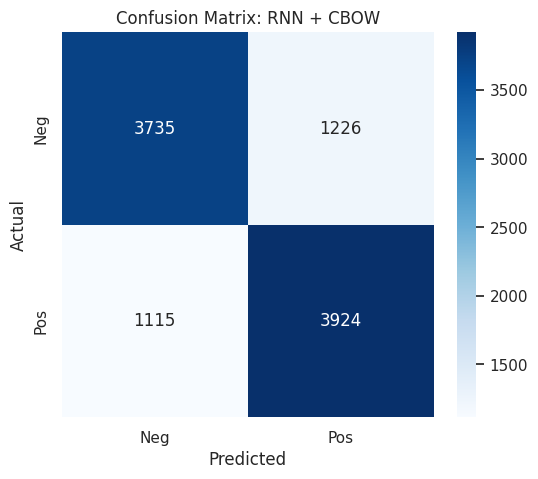

In [ ]:
# 1. Get predictions
y_pred_probs = model.predict(X_test_padded)
y_pred = (y_pred_probs > 0.5).astype(int)

# 2. Print Classification Report (Accuracy, Precision, Recall, F1)
print("--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# 3. Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
plt.title('Confusion Matrix: RNN + CBOW')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# RNN + Skip-gram

In [ ]:
# 1. Train Skip-gram (sg=1)
# Use the tokens from the already-preprocessed X_train
w2v_skip_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, sg=1, min_count=2)

# 2. Prepare the Skip-gram Embedding Matrix
embedding_matrix_skip = np.zeros((nb_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_words: continue
    if word in w2v_skip_model.wv:
        embedding_matrix_skip[i] = w2v_skip_model.wv[word]

print(f"Skip-gram Embedding Matrix Shape: {embedding_matrix_skip.shape}")

Skip-gram Embedding Matrix Shape: (10000, 100)


In [ ]:
model_skip = Sequential([
    Embedding(input_dim=nb_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix_skip],
              trainable=False),
    SimpleRNN(32),
    Dense(1, activation='sigmoid')
])

model_skip.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [ ]:
history_skip = model_skip.fit(
    X_train_padded,
    y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 32s 60ms/step - accuracy: 0.5506 - loss: 0.6874 - val_accuracy: 0.7551 - val_loss: 0.5311
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 46ms/step - accuracy: 0.7418 - loss: 0.5395 - val_accuracy: 0.7732 - val_loss: 0.4967
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.7820 - loss: 0.4824 - val_accuracy: 0.7904 - val_loss: 0.4690
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.7954 - loss: 0.4605 - val_accuracy: 0.7993 - val_loss: 0.4487
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.8054 - loss: 0.4437 - val_accuracy: 0.8120 - val_loss: 0.4287
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.8124 - loss: 0.4300 - val_accuracy: 0.8200 - val_loss: 0.4149
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - accuracy: 0.8200 - loss: 0.4166 - val_accuracy: 0.8214 - val_loss: 0.4082
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.8263 - loss: 0.4050 - 

#**Skip-gram evaluation**

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
--- Skip-gram + RNN Classification Report ---
              precision    recall  f1-score   support

    Negative       0.87      0.81      0.84      4961
    Positive       0.83      0.88      0.85      5039

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



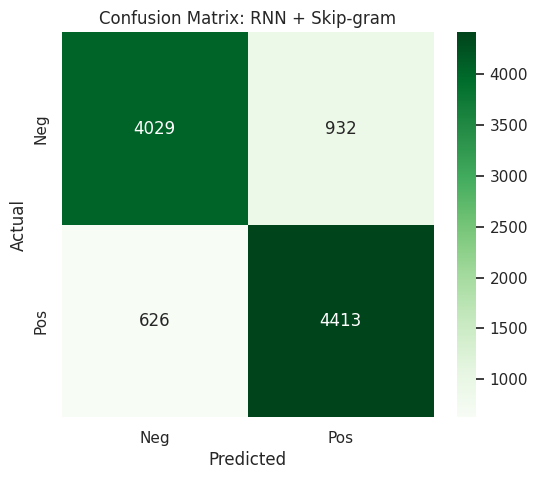

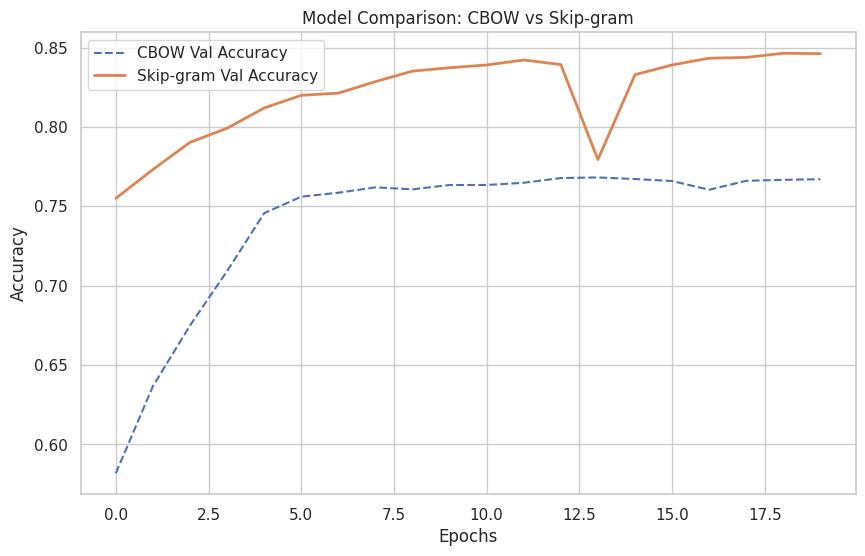

In [ ]:

# 1. Get predictions for the Skip-gram model
y_pred_probs_skip = model_skip.predict(X_test_padded)
y_pred_skip = (y_pred_probs_skip > 0.5).astype(int)

# 2. Print Classification Report
print("--- Skip-gram + RNN Classification Report ---")
print(classification_report(y_test, y_pred_skip, target_names=['Negative', 'Positive']))

# 3. Plot Confusion Matrix
cm_skip = confusion_matrix(y_test, y_pred_skip)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_skip, annot=True, fmt='d', cmap='Greens', # Different color for distinction
            xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
plt.title('Confusion Matrix: RNN + Skip-gram')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 4. Compare Learning Curves (CBOW vs Skip-gram)
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_accuracy'], label='CBOW Val Accuracy', linestyle='--')
plt.plot(history_skip.history['val_accuracy'], label='Skip-gram Val Accuracy', linewidth=2)
plt.title('Model Comparison: CBOW vs Skip-gram')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#**RNN-TF-IDF**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Create TF-IDF Vectors (Limiting to 5000 features for memory)
tfidf_vec = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vec.fit_transform(X_train).toarray()
X_test_tfidf = tfidf_vec.transform(X_test).toarray()

# 2. Reshape for RNN: (samples, 1, 5000)
# We treat the whole document as one "giant word" at one time step
X_train_tfidf_rnn = np.reshape(X_train_tfidf, (X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1]))
X_test_tfidf_rnn = np.reshape(X_test_tfidf, (X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1]))

print(f"TF-IDF Input Shape: {X_train_tfidf_rnn.shape}")

TF-IDF Input Shape: (40000, 1, 5000)


In [ ]:
model_tfidf = Sequential([
    # Input layer matches our 5000 features
    tf.keras.layers.Input(shape=(1, 5000)),
    SimpleRNN(64), # Using 64 units to handle the wider input
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_tfidf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [ ]:
# 1. Define the checkpoint specifically for the TF-IDF experiment
checkpoint_tfidf = ModelCheckpoint(
    'best_tfidf_model.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [ ]:
history_tfidf = model_tfidf.fit(
    X_train_tfidf_rnn,
    y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[checkpoint_tfidf], # TF-IDF checkpoint
    verbose=1
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9450 - loss: 0.1528
Epoch 1: val_accuracy improved from -inf to 0.86612, saving model to best_tfidf_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.9450 - loss: 0.1528 - val_accuracy: 0.8661 - val_loss: 0.3791
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9458 - loss: 0.1498
Epoch 2: val_accuracy did not improve from 0.86612
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9458 - loss: 0.1498 - val_accuracy: 0.8656 - val_loss: 0.3839
Epoch 3/20
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9466 - loss: 0.1476
Epoch 3: val_accuracy did not improve from 0.86612
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9466 - loss: 0.1476 - val_accuracy: 0.8660 - val_loss: 0.3887
Epoch 4/20
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9476 - loss: 0.1448
Epoch 4: val_accuracy did not improve from 0.86612
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accura

#**RNN-TF-IDF EVALUATION**

Successfully loaded the best TF-IDF model weights!
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
--- TF-IDF + RNN Classification Report ---
              precision    recall  f1-score   support

    Negative       0.87      0.86      0.86      4961
    Positive       0.86      0.88      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



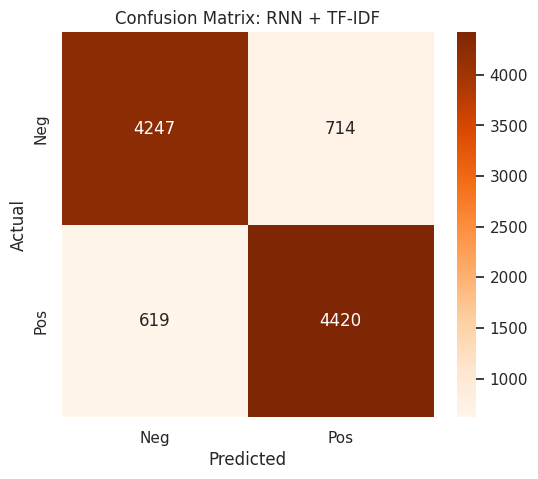

In [ ]:
# 1. Get predictions for the TF-IDF model
model_tfidf = load_model('best_tfidf_model.keras')
print("Successfully loaded the best TF-IDF model weights!")
y_pred_probs_tfidf = model_tfidf.predict(X_test_tfidf_rnn)
y_pred_tfidf = (y_pred_probs_tfidf > 0.5).astype(int)

# 2. Print Classification Report
print("--- TF-IDF + RNN Classification Report ---")
print(classification_report(y_test, y_pred_tfidf, target_names=['Negative', 'Positive']))

# 3. Plot Confusion Matrix
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
plt.title('Confusion Matrix: RNN + TF-IDF')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#**Word embeddings comparison**

,Embedding,Test Accuracy,Val Loss (Final)
0,CBOW,0.7659,0.514282
1,Skip-gram,0.8442,0.362325
2,TF-IDF,0.8667,0.459434


/tmp/ipython-input-1374770694.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Embedding', y='Test Accuracy', data=comparison_df, palette='viridis')


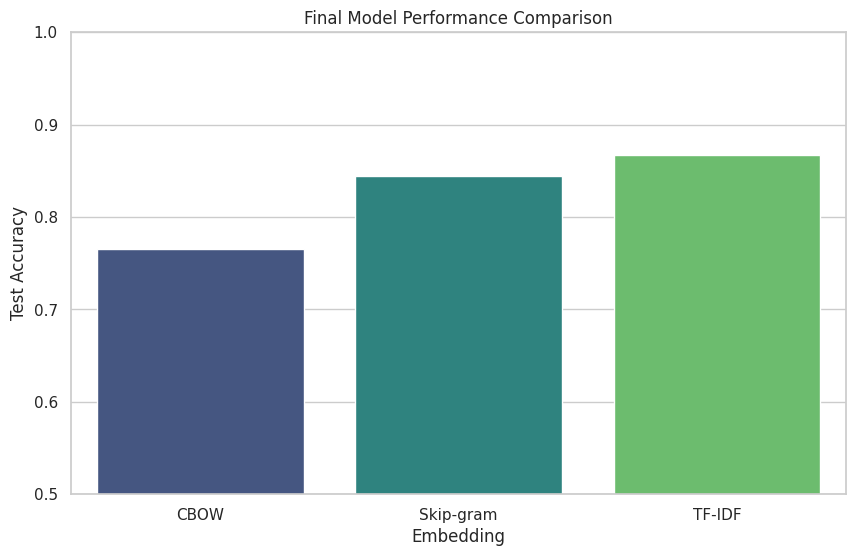

In [ ]:
results_data = {
    'Embedding': ['CBOW', 'Skip-gram', 'TF-IDF'],
    'Test Accuracy': [
        accuracy_score(y_test, y_pred),
        accuracy_score(y_test, y_pred_skip),
        accuracy_score(y_test, y_pred_tfidf)
    ],
    'Val Loss (Final)': [
        history.history['val_loss'][-1],
        history_skip.history['val_loss'][-1],
        history_tfidf.history['val_loss'][-1]
    ]
}

comparison_df = pd.DataFrame(results_data)
display(comparison_df)

# Plotting the comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Embedding', y='Test Accuracy', data=comparison_df, palette='viridis')
plt.title('Final Model Performance Comparison')
plt.ylim(0.5, 1.0) # Start at 0.5 since that's baseline (random guess)
plt.ylabel('Test Accuracy')
plt.show()

In [ ]:


# Creating the final summary table
data = {
    'Experiment': ['RNN + CBOW', 'RNN + Skip-gram', 'RNN + TF-IDF'],
    'Accuracy': [0.77, 0.84, 0.87],
    'F1-Score (Avg)': [0.77, 0.84, 0.87],
    'Notes': [
        'Stable but lowest accuracy; semantic averaging.',
        'Strongest sequential performance; handled context well.',
        'Highest accuracy; non-sequential; prone to early overfitting.'
    ]
}

comparison_table = pd.DataFrame(data)
print("Final comparison")
display(comparison_table)



Final comparison


,Experiment,Accuracy,F1-Score (Avg),Notes
0,RNN + CBOW,0.77,0.77,Stable but lowest accuracy; semantic averaging.
1,RNN + Skip-gram,0.84,0.84,Strongest sequential performance; handled cont...
2,RNN + TF-IDF,0.87,0.87,Highest accuracy; non-sequential; prone to ear...


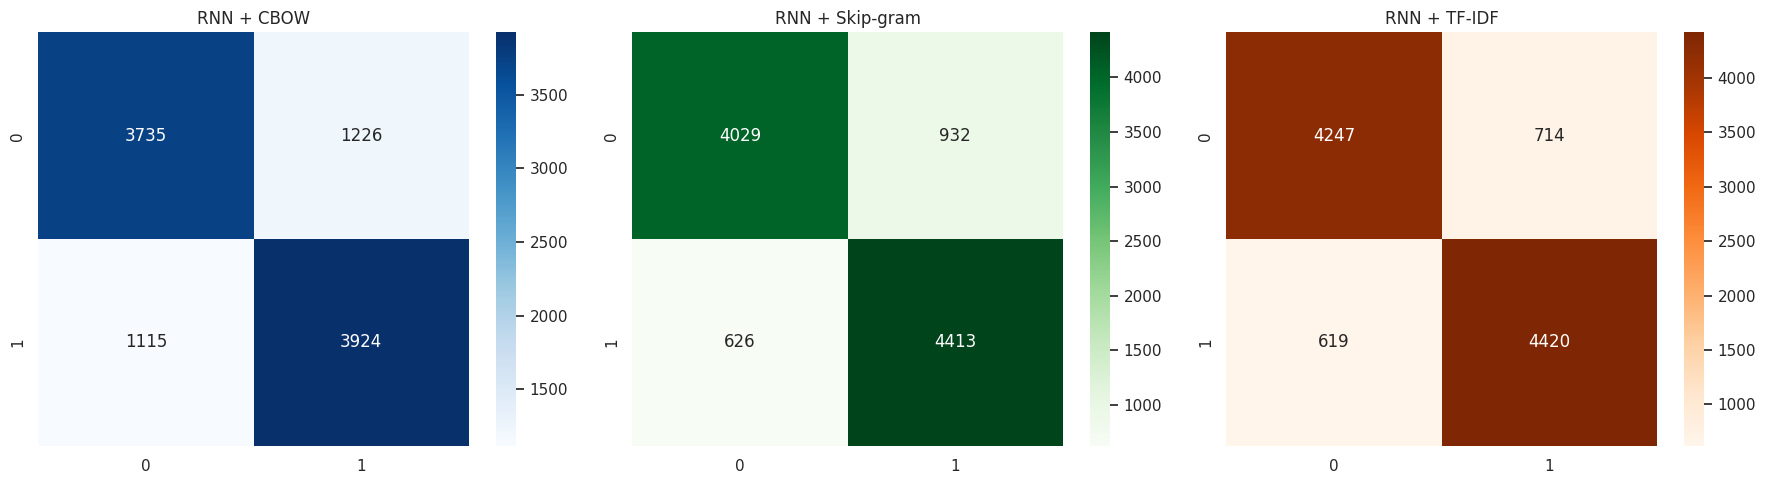

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot CBOW
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('RNN + CBOW')

# Plot Skip-gram
sns.heatmap(cm_skip, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('RNN + Skip-gram')

# Plot TF-IDF
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Oranges', ax=axes[2])
axes[2].set_title('RNN + TF-IDF')

plt.tight_layout()
plt.show()